In [1]:
## Dependencies
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from patchify import patchify, unpatchify
from skimage.io import imread

from sewar.full_ref import ssim, msssim, mse
from tqdm.notebook import tqdm
import ray
import webbrowser

# local
from NanTex_backend.Util.pyDialogue import pyDialogue as pD

In [2]:
def extract_files_from_dir(dir_path:str, file_type:str)->dict:
    if file_type in ['jpg', 'png', 'jpeg']:
        # grab all files in the directory
        files_original = glob(f"{dir_path}/feature_?*.{file_type}")
        files_dream = glob(f"{dir_path}/original_feature*.{file_type}")
        
        # load the images
        original_images = [imread(file) for file in files_original]
        dream_images = [imread(file) for file in files_dream]
        return { 'original': original_images, 'dream': dream_images }
    elif file_type == 'npy':
        # grab all files in the directory
        files_original = glob(f"{dir_path}/feature_?*.npy")
        files_dream = glob(f"{dir_path}/original_feature*.npy")
        
        # load the images
        original_images = [np.load(file) for file in files_original]
        dream_images = [np.load(file) for file in files_dream]
        return { 'original': original_images, 'dream': dream_images }

In [3]:
# grab data
directories:list = pD.askDIRS() ## just choose the partent directory where all dream folders containing the images are
files:dict = {dir_path.split('\\')[-1]: extract_files_from_dir(dir_path, 'npy') for dir_path in directories}

## Global Eval

In [40]:
# global evaluation
# currently, we will only caclulate SSIM, MSSSIM and MSE

@ray.remote
def global_eval(in_tuple:tuple)->dict:
    # unpack
    dream_key, dream = in_tuple
    # out
    out = {}
    # pass the images through the evaluation
    for feature_index in range(len(dream['original'])):
        out[f"feature_{feature_index}"] = {}
        # calculate the evaluation
        for eval in [mse, ssim, msssim]:
            out[f"feature_{feature_index}"][eval.__name__] = eval(dream['original'][feature_index], 
                                                                  dream['dream'][feature_index])
            # cleanup
            if eval.__name__ == 'ssim':
                out[f"feature_{feature_index}"][eval.__name__] = out[f"feature_{feature_index}"][eval.__name__][0]
            if eval.__name__ == 'msssim':
                out[f"feature_{feature_index}"][eval.__name__] = np.real(out[f"feature_{feature_index}"][eval.__name__])
    dream['global_eval'] = out
    return dream_key, dream

In [ ]:
# spinup ray instance
context = ray.init(num_cpus=12, # <-------- change this to the number of cpus you have
                   num_gpus=0,  # leave this as 0
                   ignore_reinit_error=True)
# automatically open the ray dashboard
ray_dashboard_url = f"http://{context.address_info['webui_url']}"
webbrowser.open(ray_dashboard_url, new=2, autoraise=True)

In [41]:
# offload the evaluation to the ray instance
file_pointers:list = [ray.put((key,files[key])) for key in files.keys()]
state_pointers:list = [global_eval.remote(pointer) for pointer in file_pointers]

finished_global_states = []

# loop through the directories
with tqdm(total=len(state_pointers)) as pbar:
    while len(state_pointers) > 0:
        try:
            finished, state_pointers = ray.wait(state_pointers, 
                                                timeout = 8.0)
            data = ray.get(finished)
            finished_global_states.extend(data)
            pbar.n = len(finished_global_states)
            pbar.refresh()
        except KeyboardInterrupt:
            break

  0%|          | 0/25 [00:00<?, ?it/s]

In [42]:
# reconstruct the complete dictionary
files = {key: value for key, value in finished_global_states}

# extract the global evaluation
global_eval_dict = {key: value['global_eval'] for key, value in finished_global_states}
global_eval_dict['average'] = {feature_key:{eval_key: np.mean([value[feature_key][eval_key] 
                                                               for value in global_eval_dict.values()]) 
                                            for eval_key in global_eval_dict['dream_0']['feature_0'].keys()} 
                               for feature_key in global_eval_dict['dream_0'].keys()}
global_eval_dict['average']

{'feature_0': {'mse': 178.4107625626929,
  'ssim': 0.7252014152041643,
  'msssim': 0.8767010588979861},
 'feature_1': {'mse': 493.36763249903555,
  'ssim': 0.7580352529228652,
  'msssim': 0.8695472699770683}}

In [43]:
ray.shutdown()

## Local Eval

In [33]:
# patchify and linearize
def patchify_and_linearize(image:np.ndarray, patch_size:tuple)->np.ndarray:
    out = patchify(image, patch_size, step=patch_size[1]).reshape(-1, patch_size[0], patch_size[1])
    return out
def unpatchify_from_linear(patch_array:np.ndarray, img_size:tuple, patch_size:tuple)->np.ndarray:
    out = unpatchify(patch_array.reshape(np.sqrt(patch_array.shape[0]).astype(int), np.sqrt(patch_array.shape[0]).astype(int), patch_size[0], patch_size[1]), img_size)
    return out

In [34]:
## Ray worker for local evaluation
@ray.remote
def local_eval(in_tuple:tuple)->float:
    # unpack
    dream_key, dream = in_tuple
    # out
    out = {}    
    # pass each patch pair through the eval
    for feature_index in range(len(dream['original'])):
        # patchify and linearize
        dream_linear = patchify_and_linearize(dream['dream'][feature_index], (64, 64))          # <--- change this to set the patch size
        original_linear = patchify_and_linearize(dream['original'][feature_index], (64, 64))    # <--- change this to set the patch size
        # create contaienr
        patch_out = {}
        # pass through eval
        for patch_index in range(dream_linear.shape[0]):
            metric_out = {}
            for eval in [mse, ssim, msssim]:
                current_out = eval(GT = original_linear[patch_index], P = dream_linear[patch_index])
                
                # cleanup
                if eval.__name__ == 'ssim':
                    current_out = current_out[0]
                if eval.__name__ == 'msssim':
                    current_out = np.real(current_out)
                
                # reassemble
                metric_out[eval.__name__] = current_out
            patch_out[f"patch_{patch_index}"] = metric_out
        out[f"feature_{feature_index}"] = patch_out
    dream['local_eval'] = out
    
    return dream_key, dream

In [35]:
# spinup ray instance
context = ray.init(num_cpus=12, # <-------- change this to the number of cpus you have
                   num_gpus=0,  # leave this as 0
                   ignore_reinit_error=True)
# automatically open the ray dashboard
ray_dashboard_url = f"http://{context.address_info['webui_url']}"
webbrowser.open(ray_dashboard_url, new=2, autoraise=True)

2025-01-07 20:42:48,993	INFO worker.py:1654 -- Calling ray.init() again after it has already been called.


True

In [36]:
# offload the evaluation to the ray instance
file_pointers:list = [ray.put((key,files[key])) for key in files.keys()]
state_pointers:list = [local_eval.remote(pointer) for pointer in file_pointers]

finished_local_states = []

# loop through the directories
with tqdm(total=len(state_pointers)) as pbar:
    while len(state_pointers) > 0:
        try:
            finished, state_pointers = ray.wait(state_pointers, 
                                                timeout = 8.0)
            data = ray.get(finished)
            finished_local_states.extend(data)
            pbar.n = len(finished_local_states)
            pbar.refresh()
        except KeyboardInterrupt:
            break

  0%|          | 0/25 [00:00<?, ?it/s]

In [37]:
# reconstruct the complete dictionary
files = {key: value for key, value in finished_local_states}

# extract the global evaluation
local_eval_dict = {key: value['local_eval'] for key, value in finished_local_states}

In [38]:
## Generate Colored Overlays for the Local Evaluation to be used in figures
def create_patched_overlays(local_eval:np.ndarray, patch_size:tuple, img_size:tuple)->np.ndarray:
    # create overlay mask
    overlay_mask = np.ones(patch_size)
    # metrics
    metric_keys = list(local_eval['feature_0']['patch_0'].keys())
    # scale with local eval
    overlay = {feature_key: {metric_key: 
        unpatchify_from_linear(
            np.stack([overlay_mask * local_eval[feature_key][patch_key][metric_key] for patch_key in local_eval[feature_key].keys()],
                     axis = 0),
            img_size,
            patch_size)
            for metric_key in metric_keys} 
        for feature_key in local_eval.keys()}
    
    return overlay

overlay_dict = {dream_key: create_patched_overlays(local_eval_dict[dream_key], 
                                                   (64, 64), # <--- change this to set the patch size                        
                                                   files[dream_key]['dream'][0].shape) 
                for dream_key in files.keys()}

Text(0.5, 1.0, 'ssim')

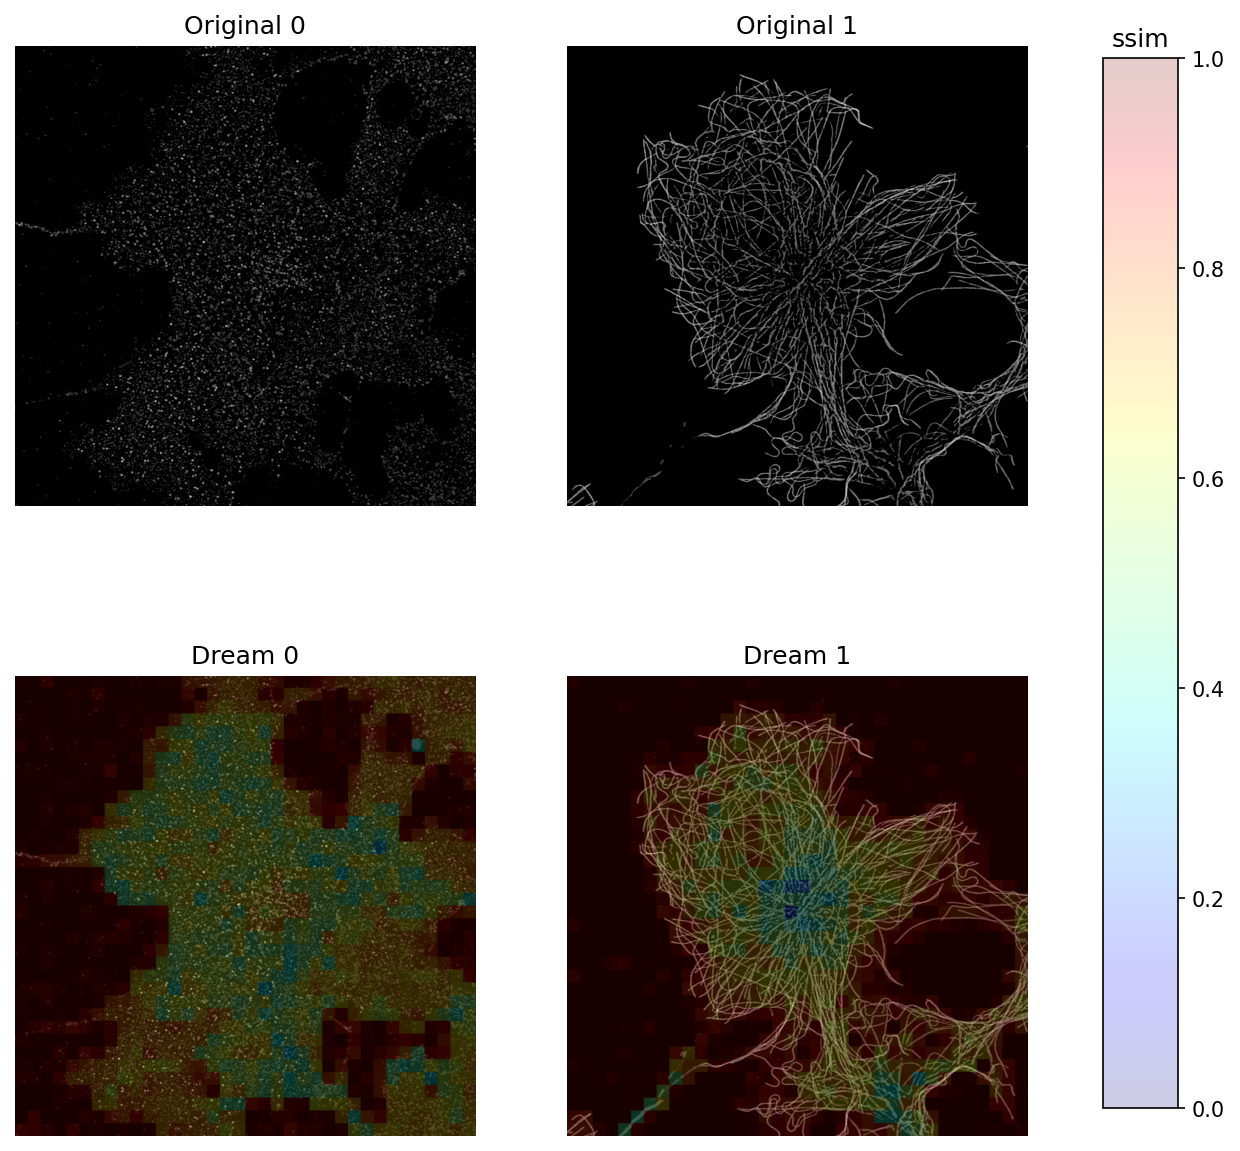

In [39]:
## Plot Overlays

dream_key:str = 'dream_0'
metric_key:str = 'ssim'

fig, axs = plt.subplots(2,len(files[dream_key]['dream']),figsize = (10,10), dpi = 150)
# plot original and dream with colorful overlay

# original
for i, original in enumerate(files[dream_key]['original']):
    axs[0,i].imshow(original, cmap = 'gray')
    axs[0,i].axis('off')
    axs[0,i].set_title(f"Original {i}")
    
# dream
for i, dream in enumerate(files[dream_key]['dream']):
    axs[1,i].imshow(dream, cmap = 'gray')
    img = axs[1,i].imshow(overlay_dict[dream_key][f'feature_{i}'][metric_key], cmap = 'jet', alpha = 0.2, vmin = 0, vmax = 1)
    axs[1,i].axis('off')
    axs[1,i].set_title(f"Dream {i}")
    
# add horizontal colorbar at the bottom
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(img, cax=cbar_ax, orientation='vertical')
cbar_ax.set_title(metric_key)